In [37]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*algorithm did not converge.*")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

PHASE1_DIR = Path(".")
PROCESSED_DIR = PHASE1_DIR / "processed"

In [38]:
evaluations_df = pd.read_parquet(PROCESSED_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [39]:
from src.split import get_n_splits
from src.evaluation import evaluate_model_with_cross_validation

In [29]:
from src.survival_function_wrapper import SurvivalFunctionWrapper
from sksurv.linear_model import CoxPHSurvivalAnalysis

wrapper = SurvivalFunctionWrapper(
    model_cls=CoxPHSurvivalAnalysis,
    risk_function="linear",
    alpha=0.1,
    ties="efron"
)

splits = get_n_splits(df, n=2, instance_number=10, solver_number=300, random_state=0)
result = evaluate_model_with_cross_validation(
    df,
    wrapper=wrapper,
    splits=splits,
    const_cut_off=10.0,
    random_state=0,
)

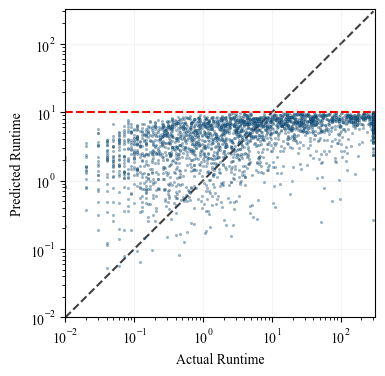

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sc = ax.scatter(
    result["y_test_not_censored"],
    result["y_pred"],
    alpha=0.5,
    edgecolors="k",
    lw=0.2,
    s=3,
)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(0.01, 320)
ax.set_ylim(0.01, 320)
ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
ax.axhline(y=10, color='red', linestyle='--')

ax.set_ylabel("Predicted Runtime")
ax.set_xlabel("Actual Runtime")
plt.show()

In [31]:
# from src.split import permutate_df_by_cost_decreasing

# train_idx, test_idx = next(get_n_splits(df, n=2, instance_number=10, solver_number=300, random_state=0))

# df_train = df.loc[train_idx]
# df_train, cut_off_train = permutate_df_by_cost_decreasing(df_train, lognormal_mean=0, lognormal_sigma=1, random_state=0)
# X_train = df_train.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
# y_train = df_train["cost"].clip(upper=cut_off_train).to_numpy()

# df_test = df.loc[test_idx]
# df_test, cut_off_test = permutate_df_by_cost_decreasing(df_test, lognormal_mean=0, lognormal_sigma=1, random_state=0)
# X_test = df_test.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
# y_test = df_test["cost"].clip(upper=cut_off_test).to_numpy()
# y_test_not_censored = df_test["cost"].to_numpy()

In [ ]:
# from sksurv.linear_model import CoxPHSurvivalAnalysis

# y_ndarr = np.zeros(X_train.shape[0], dtype=[("not_censored", bool), ("cost", float)])
# y_ndarr["not_censored"] = y_train < cut_off_train
# y_ndarr["cost"] = y_train

# CoxPHSurvivalAnalysis(
#     alpha=0.1,
#     ties="breslow",
# ).fit(X_train, y_ndarr).predict(X_test)